# !pip install pyro-ppl

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from IPython import display
import os
from PIL import Image, ImageOps
from torch.utils.data.dataset import Dataset
from scipy.misc import imread

In [3]:
%matplotlib inline

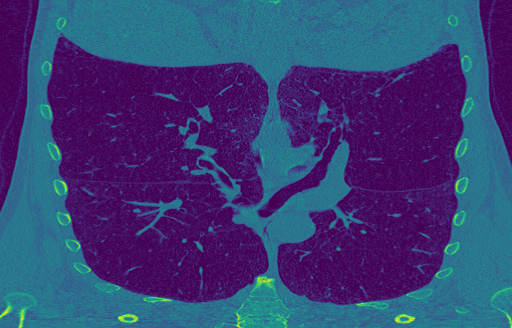

In [4]:
image = Image.open("D:/Lung cancer LNDb project/dataset/slices/coronal_image/1/LNDb-0001_294.png")
image

In [5]:
image = image.resize((28,28))

In [6]:
image = np.asarray(ImageOps.grayscale(image)).T

In [7]:
image.shape

(28, 28)

In [10]:
class data_loader(Dataset):
    def __init__(self, root):
        Images, Y = [], []
        folders = os.listdir(root)
        folders = folders[0:]

        for folder in folders:
            folder_path = os.path.join(root, folder)
            print(folder_path)
            count = 0
            for ims in os.listdir(folder_path):
                if count >= 5700:
                    break
                count += 1
                img_path = os.path.join(folder_path, ims)
                rgbv = Image.open(img_path)
                rgbv = rgbv.resize((28,28))
                gray = ImageOps.grayscale(rgbv)
                Images.append(np.asarray(gray).T)
                Y.append(int(folder))  # Folders are A-J so labels will be 0-9
                data = [(x, y) for x, y in zip(Images, Y)]
                self.data = data
    def __len__(self):
        return len(self.data)
    def __getitem__(self, index):
        img = self.data[index][0]

    # 8 bit images. Scale between 0, 1
        img = img / 255

    # Input for Conv2D should be Channels x Height x Width
        img_tensor = transforms.ToTensor()(img).view(1, 28, 28).float()
        label = self.data[index][1]
        return (img_tensor, label)

In [11]:
train_dataset = data_loader('D:/Lung cancer LNDb project/dataset/slices/coronal_image/')
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

D:/Lung cancer LNDb project/dataset/slices/coronal_image/0
D:/Lung cancer LNDb project/dataset/slices/coronal_image/1


In [12]:
test_dataset = data_loader("D:/Lung cancer LNDb project/dataset/slices/coronal_test")
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)

D:/Lung cancer LNDb project/dataset/slices/coronal_test\0
D:/Lung cancer LNDb project/dataset/slices/coronal_test\1


In [13]:
class NN(nn.Module):
    
    def __init__(self, input_size, hidden_size, output_size):
        super(NN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        output = self.fc1(x)
        output = F.relu(output)
        output = self.out(output)
        return output

In [14]:
net = NN(28*28, 1024, 2)

In [15]:
import pyro
from pyro.distributions import Normal, Categorical
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam

In [16]:
log_softmax = nn.LogSoftmax(dim=1)

In [17]:
def model(x_data, y_data):
    
    fc1w_prior = Normal(loc=torch.zeros_like(net.fc1.weight), scale=torch.ones_like(net.fc1.weight))
    fc1b_prior = Normal(loc=torch.zeros_like(net.fc1.bias), scale=torch.ones_like(net.fc1.bias))
    
    outw_prior = Normal(loc=torch.zeros_like(net.out.weight), scale=torch.ones_like(net.out.weight))
    outb_prior = Normal(loc=torch.zeros_like(net.out.bias), scale=torch.ones_like(net.out.bias))
    
    priors = {'fc1.weight': fc1w_prior, 'fc1.bias': fc1b_prior,  'out.weight': outw_prior, 'out.bias': outb_prior}
    # lift module parameters to random variables sampled from the priors
    lifted_module = pyro.random_module("module", net, priors)
    # sample a regressor (which also samples w and b)
    lifted_reg_model = lifted_module()
    
    lhat = log_softmax(lifted_reg_model(x_data))
    
    pyro.sample("obs", Categorical(logits=lhat), obs=y_data)

In [18]:
softplus = torch.nn.Softplus()

def guide(x_data, y_data):
    
    # First layer weight distribution priors
    fc1w_mu = torch.randn_like(net.fc1.weight)
    fc1w_sigma = torch.randn_like(net.fc1.weight)
    fc1w_mu_param = pyro.param("fc1w_mu", fc1w_mu)
    fc1w_sigma_param = softplus(pyro.param("fc1w_sigma", fc1w_sigma))
    fc1w_prior = Normal(loc=fc1w_mu_param, scale=fc1w_sigma_param)
    # First layer bias distribution priors
    fc1b_mu = torch.randn_like(net.fc1.bias)
    fc1b_sigma = torch.randn_like(net.fc1.bias)
    fc1b_mu_param = pyro.param("fc1b_mu", fc1b_mu)
    fc1b_sigma_param = softplus(pyro.param("fc1b_sigma", fc1b_sigma))
    fc1b_prior = Normal(loc=fc1b_mu_param, scale=fc1b_sigma_param)
    # Output layer weight distribution priors
    outw_mu = torch.randn_like(net.out.weight)
    outw_sigma = torch.randn_like(net.out.weight)
    outw_mu_param = pyro.param("outw_mu", outw_mu)
    outw_sigma_param = softplus(pyro.param("outw_sigma", outw_sigma))
    outw_prior = Normal(loc=outw_mu_param, scale=outw_sigma_param).independent(1)
    # Output layer bias distribution priors
    outb_mu = torch.randn_like(net.out.bias)
    outb_sigma = torch.randn_like(net.out.bias)
    outb_mu_param = pyro.param("outb_mu", outb_mu)
    outb_sigma_param = softplus(pyro.param("outb_sigma", outb_sigma))
    outb_prior = Normal(loc=outb_mu_param, scale=outb_sigma_param)
    priors = {'fc1.weight': fc1w_prior, 'fc1.bias': fc1b_prior, 'out.weight': outw_prior, 'out.bias': outb_prior}
    
    lifted_module = pyro.random_module("module", net, priors)
    
    return lifted_module()

In [19]:
optim = Adam({"lr": 0.01})
svi = SVI(model, guide, optim, loss=Trace_ELBO())

In [20]:
num_iterations = 30
loss = 0
list_epoch = []
list_loss = []
for j in range(num_iterations):
    loss = 0
    for batch_id, data in enumerate(train_loader):
        # calculate the loss and take a gradient step
        loss += svi.step(data[0].view(-1,28*28), data[1])
    normalizer_train = len(train_loader.dataset)
    total_epoch_loss_train = loss / normalizer_train
    
    print("Epoch ", j, " Loss ", total_epoch_loss_train)
    list_epoch.append(total_epoch_loss_train)
    list_loss.append(j)

C:\Users\LNS\Anaconda3\lib\site-packages\pyro\primitives.py:406: FutureWarning: The `random_module` primitive is deprecated, and will be removed in a future release. Use `pyro.nn.Module` to create Bayesian modules from `torch.nn.Module` instances.
  "modules from `torch.nn.Module` instances.", FutureWarning)


Epoch  0  Loss  5431.7333368339405
Epoch  1  Loss  4572.25124873096
Epoch  2  Loss  3776.817095738942
Epoch  3  Loss  3243.54556365559
Epoch  4  Loss  2784.695349202046
Epoch  5  Loss  2419.3153816012227
Epoch  6  Loss  2168.4220722394816
Epoch  7  Loss  1865.3435167768755
Epoch  8  Loss  1642.5269223648206
Epoch  9  Loss  1429.9436790759416
Epoch  10  Loss  1239.5097343237044
Epoch  11  Loss  1127.5936301730076
Epoch  12  Loss  997.2058628481103
Epoch  13  Loss  872.8177549191735
Epoch  14  Loss  784.8013136018682
Epoch  15  Loss  702.1630553113368
Epoch  16  Loss  624.0384406096475
Epoch  17  Loss  553.0710016017944
Epoch  18  Loss  512.8227138399033
Epoch  19  Loss  476.0411358233711
Epoch  20  Loss  413.37710304432795
Epoch  21  Loss  399.46764685558645
Epoch  22  Loss  371.9033468466579
Epoch  23  Loss  340.9355929585716
Epoch  24  Loss  340.0962623456905
Epoch  25  Loss  341.2014549102595
Epoch  26  Loss  305.8591505401072
Epoch  27  Loss  272.6115351719292
Epoch  28  Loss  265.0

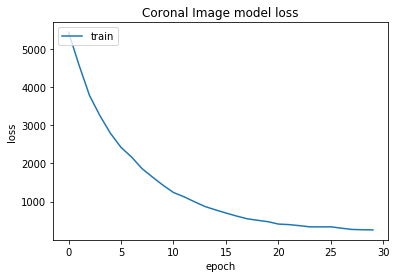

In [32]:
# summarize history for loss
plt.plot(list_loss,list_epoch)
# plt.plot(history.history['val_loss'])
plt.title('Coronal Image model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [22]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    #plt.imshow(npimg,  cmap='gray')
    #fig.show(figsize=(1,1))
    
    fig, ax = plt.subplots(figsize=(1, 1))
    ax.imshow(npimg,  cmap='gray', interpolation='nearest')
    plt.show()

In [23]:
classes = ('0', '1')

In [24]:
num_samples = 10
def give_uncertainities(x):
    sampled_models = [guide(None, None) for _ in range(num_samples)]
    yhats = [F.log_softmax(model(x.view(-1,28*28)).data, 1).detach().numpy() for model in sampled_models]
    return np.asarray(yhats)
    #mean = torch.mean(torch.stack(yhats), 0)
    #return np.argmax(mean, axis=1)

In [29]:
def test_batch(images, labels, plot=True):
    y = give_uncertainities(images)
    predicted_for_images = 0
    correct_predictions=0

    for i in range(len(labels)):
    
        if(plot):
            print("Real: ",labels[i].item())
            fig, axs = plt.subplots(1, 2, sharey=True,figsize=(20,2))
    
        all_digits_prob = []
    
        highted_something = False
    
        for j in range(len(classes)):
        
            highlight=False
        
            histo = []
            histo_exp = []
        
            for z in range(y.shape[0]):
                histo.append(y[z][i][j])
                histo_exp.append(np.exp(y[z][i][j]))
            
            prob = np.percentile(histo_exp, 50) #sampling median probability
        
            if(prob>0.2): #select if network thinks this sample is 20% chance of this being a label
                highlight = True #possibly an answer
        
            all_digits_prob.append(prob)
            
            if(plot):
            
                N, bins, patches = axs[j].hist(histo, bins=8, color = "lightgray", lw=0,  weights=np.ones(len(histo)) / len(histo), density=False)
                axs[j].set_title(str(j)+" ("+str(round(prob,2))+")") 
        
            if(highlight):
            
                highted_something = True
                
                if(plot):

                    # We'll color code by height, but you could use any scalar
                    fracs = N / N.max()

                    # we need to normalize the data to 0..1 for the full range of the colormap
                    norm = colors.Normalize(fracs.min(), fracs.max())

                    # Now, we'll loop through our objects and set the color of each accordingly
                    for thisfrac, thispatch in zip(fracs, patches):
                        color = plt.cm.viridis(norm(thisfrac))
                        thispatch.set_facecolor(color)

    
        if(plot):
            plt.show()
    
        predicted = np.argmax(all_digits_prob)
    
        if(highted_something):
            predicted_for_images+=1
            if(labels[i].item()==predicted):
                if(plot):
                    print("Correct")
                correct_predictions +=1.0
            else:
                if(plot):
                    print("Incorrect :()")
        else:
            if(plot):
                print("Undecided.")
        
        if(plot):
            imshow(images[i].squeeze())
        
    
    if(plot):
        print("Summary")
        print("Total images: ",len(labels))
        print("Predicted for: ",predicted_for_images)
        print("Accuracy when predicted: ",correct_predictions/predicted_for_images)
        
    return len(labels), correct_predictions, predicted_for_images 
    

In [31]:
# Prediction when network can decide not to predict

print('Prediction when network can refuse')
correct = 0
total = 0
total_predicted_for = 0
for j, data in enumerate(test_loader):
    images, labels = data
    
    total_minibatch, correct_minibatch, predictions_minibatch = test_batch(images, labels, plot=False)
    total += total_minibatch
    correct += correct_minibatch
    total_predicted_for += predictions_minibatch

print("Total images: ", total)
print("Skipped: ", total-total_predicted_for)
print("Accuracy when made predictions: %d %%" % (100 * correct / total_predicted_for))


Prediction when network can refuse
Total images:  78
Skipped:  0
Accuracy when made predictions: 100 %


In [27]:
# preparing for evaluation

dataiter = iter(test_loader)
images, labels = dataiter.next()

Real:  1


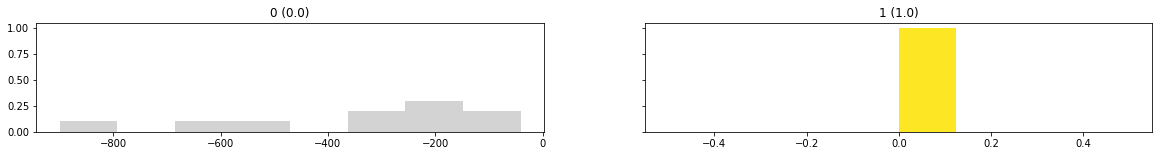

Correct


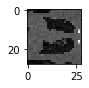

Real:  1


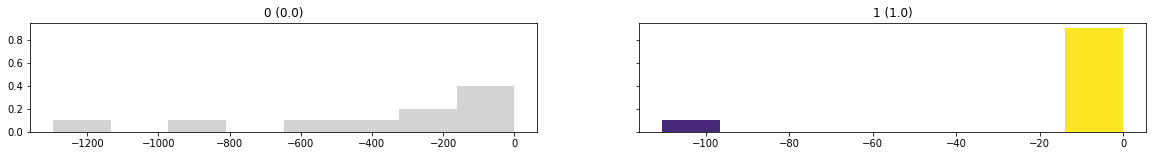

Correct


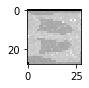

Real:  0


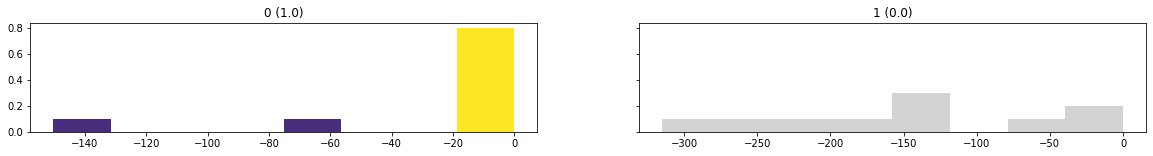

Correct


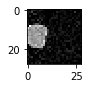

Real:  1


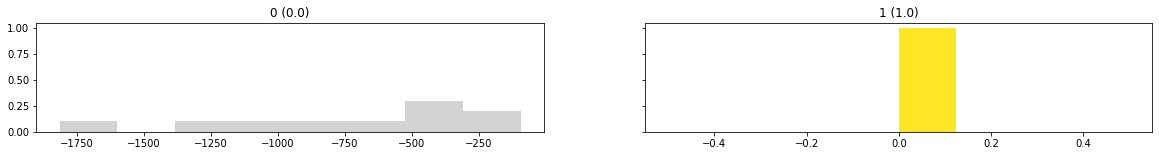

Correct


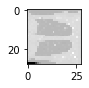

Real:  0


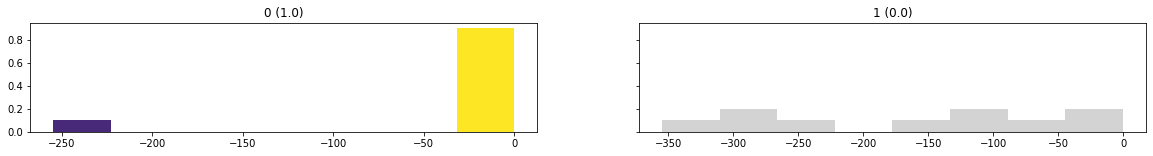

Correct


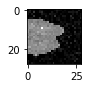

Real:  1


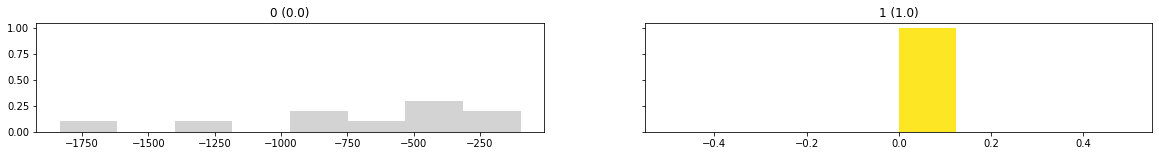

Correct


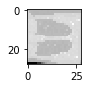

Real:  0


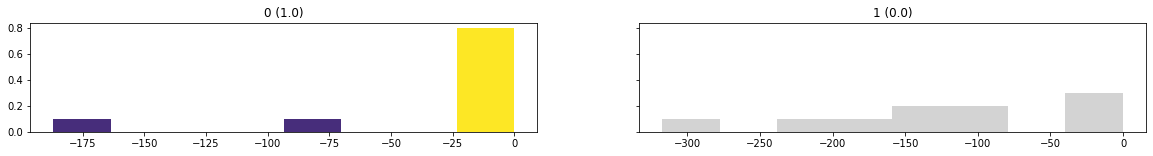

Correct


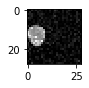

Real:  0


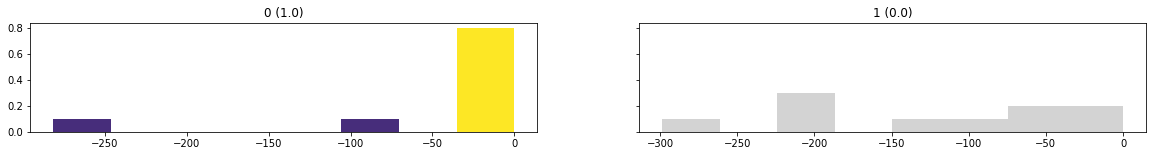

Correct


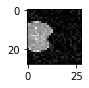

Real:  0


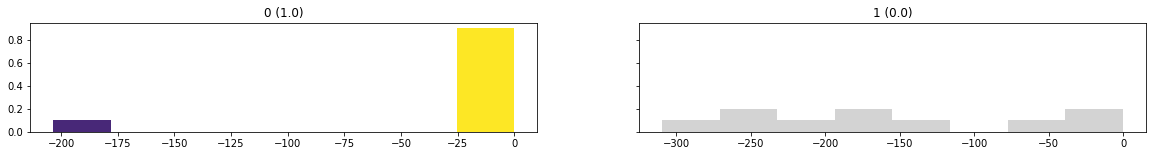

Correct


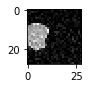

Real:  0


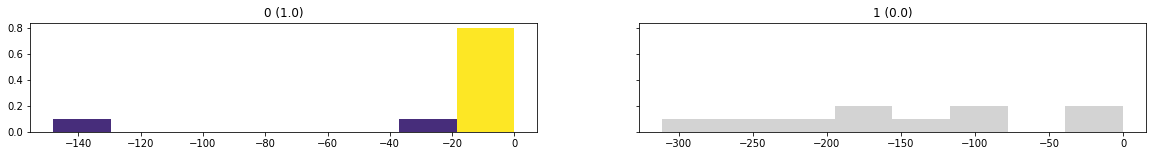

Correct


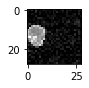

Real:  1


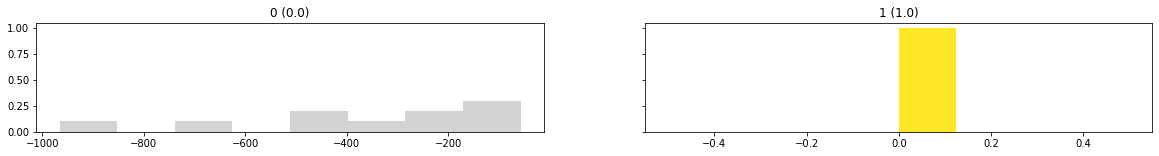

Correct


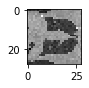

Real:  0


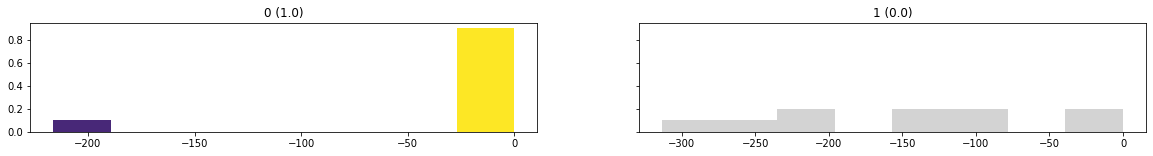

Correct


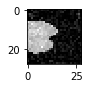

Real:  1


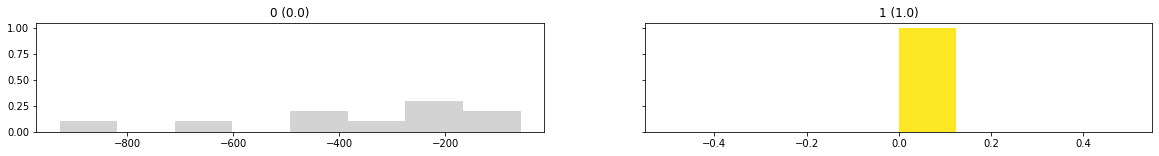

Correct


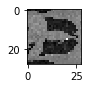

Real:  1


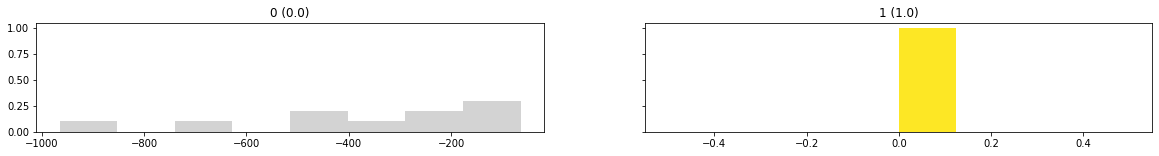

Correct


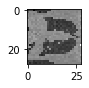

Real:  0


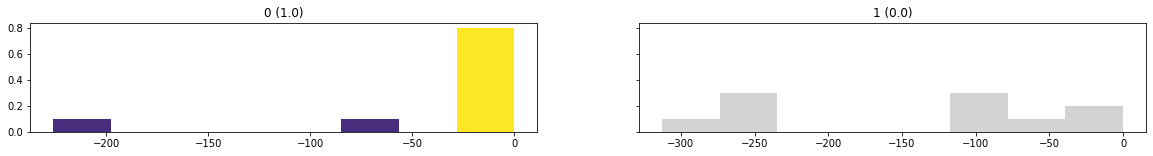

Correct


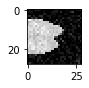

Real:  0


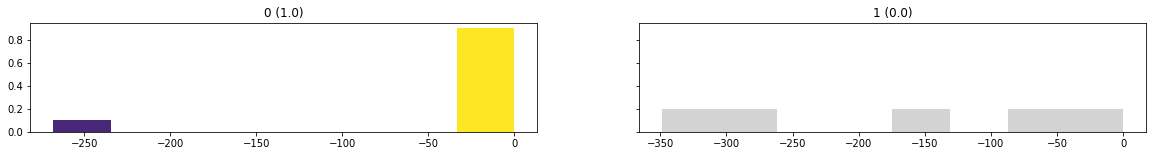

Correct


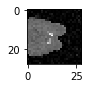

Real:  0


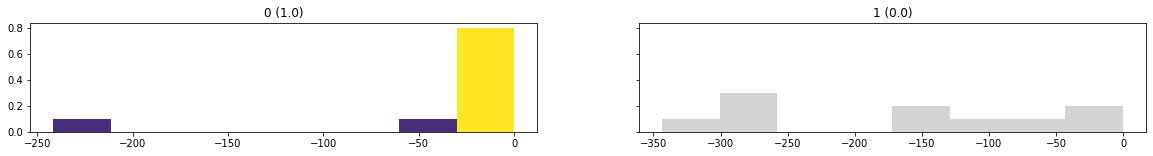

Correct


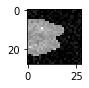

Real:  1


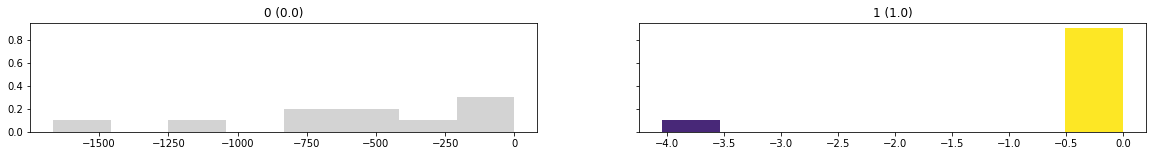

Correct


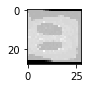

Real:  1


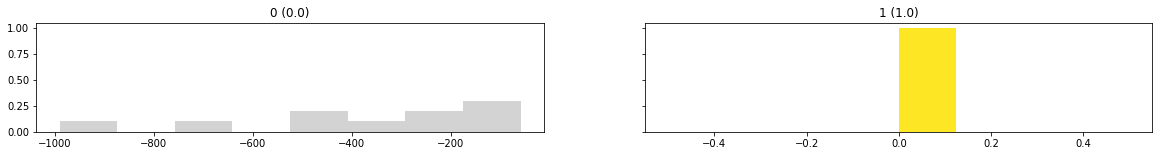

Correct


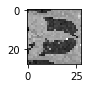

Real:  0


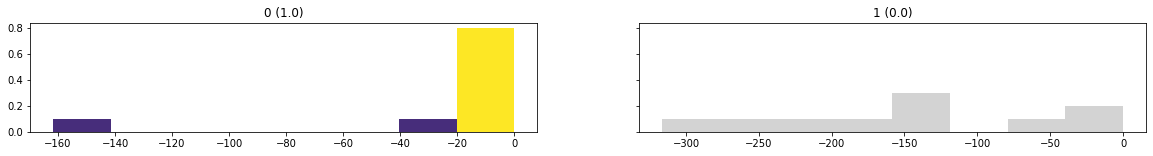

Correct


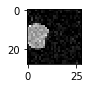

Real:  1


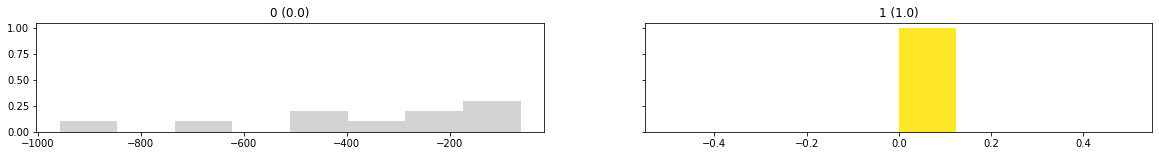

Correct


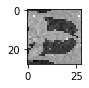

Real:  0


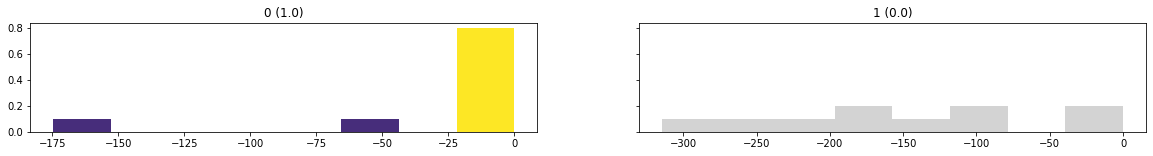

Correct


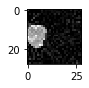

Real:  0


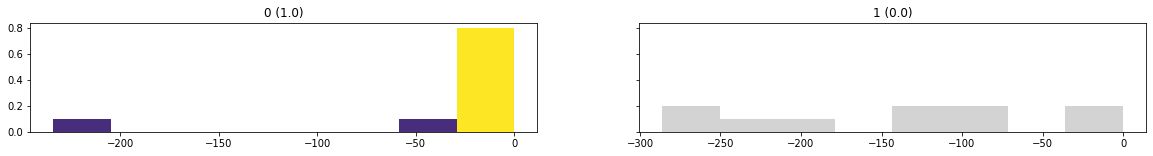

Correct


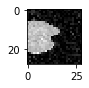

Real:  1


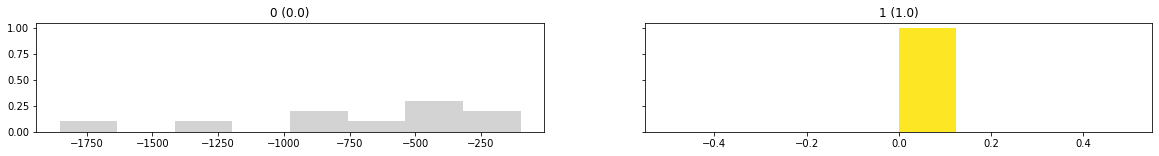

Correct


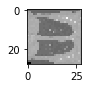

Real:  1


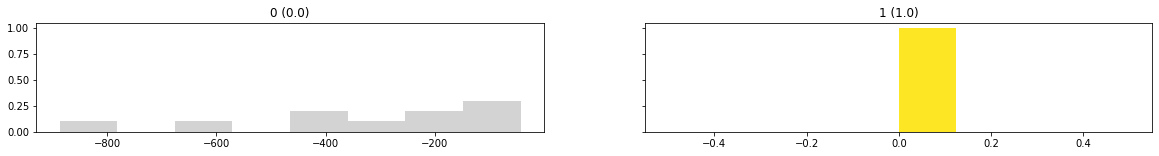

Correct


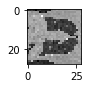

Real:  0


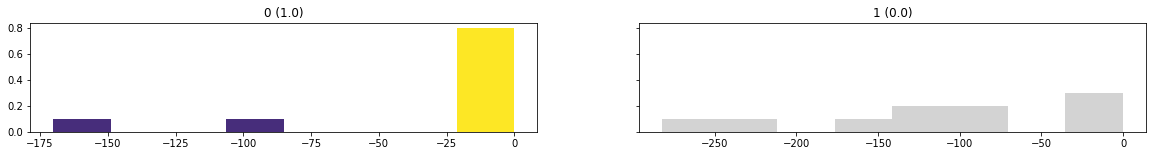

Correct


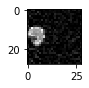

Real:  0


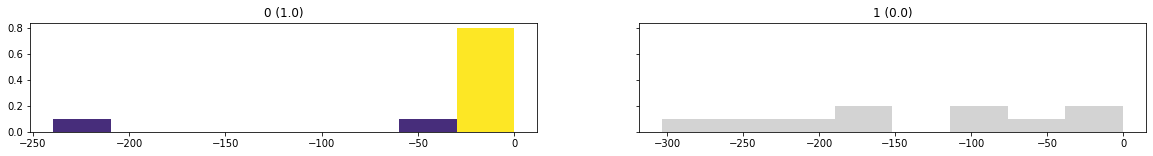

Correct


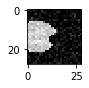

Real:  1


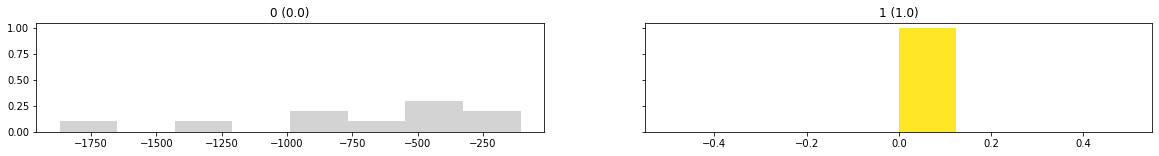

Correct


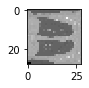

Real:  1


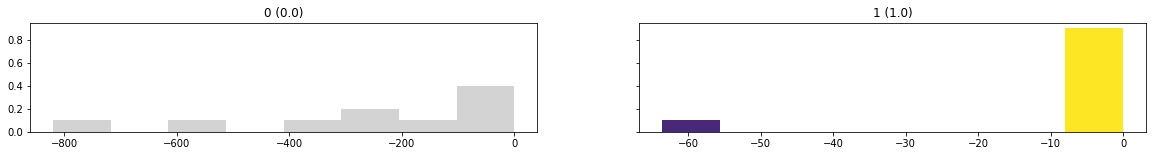

Correct


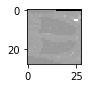

Real:  1


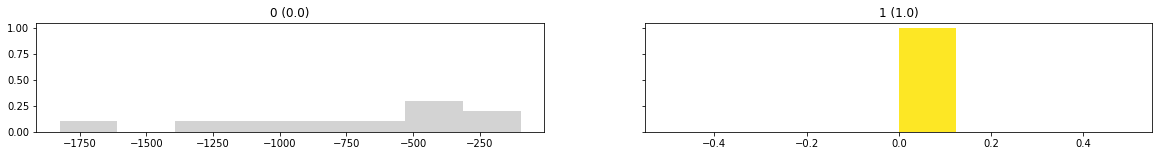

Correct


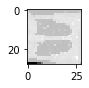

Real:  1


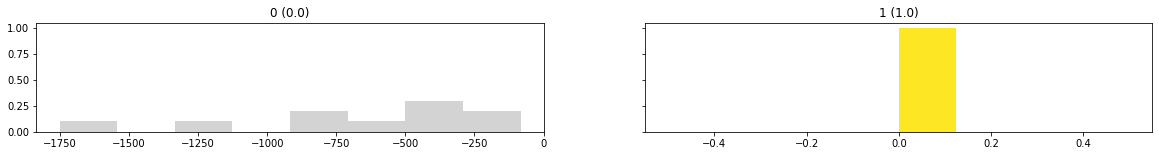

Correct


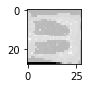

Real:  1


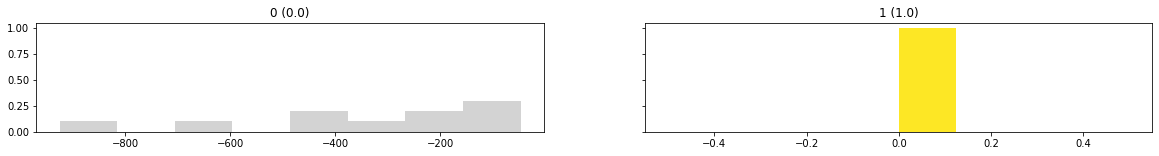

Correct


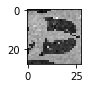

Real:  1


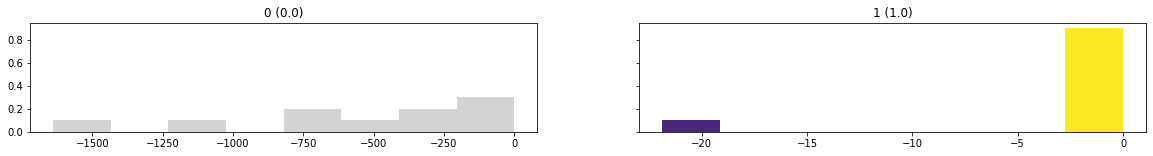

Correct


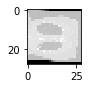

Real:  1


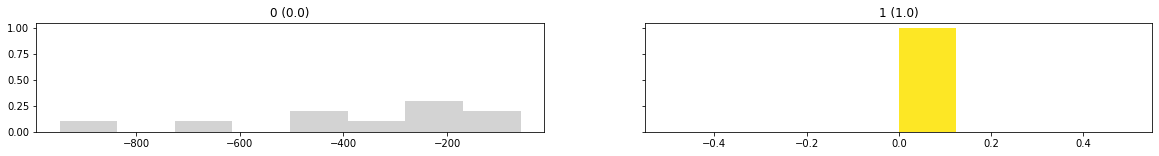

Correct


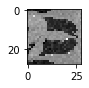

Real:  0


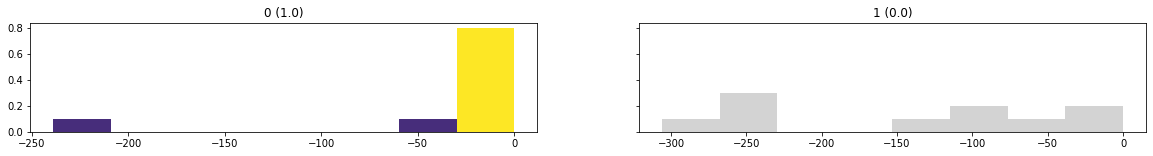

Correct


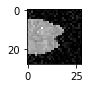

Real:  0


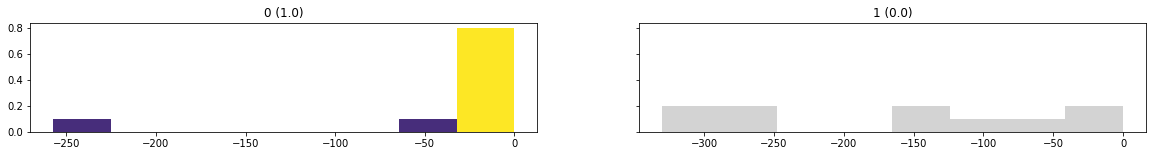

Correct


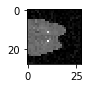

Real:  0


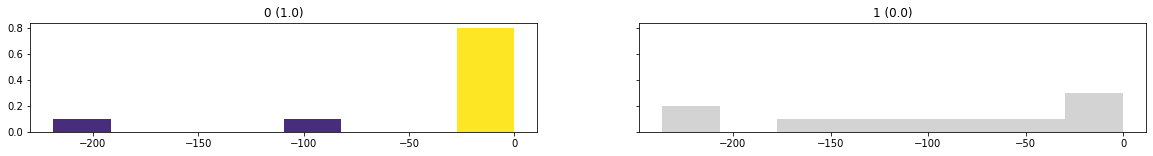

Correct


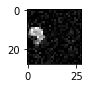

Real:  0


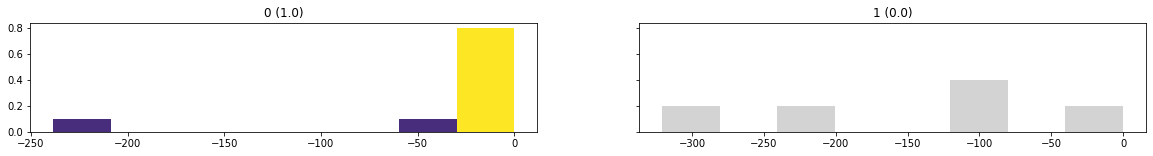

Correct


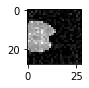

Real:  1


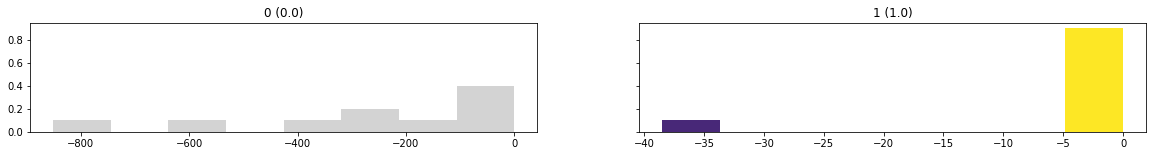

Correct


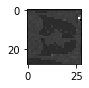

Real:  0


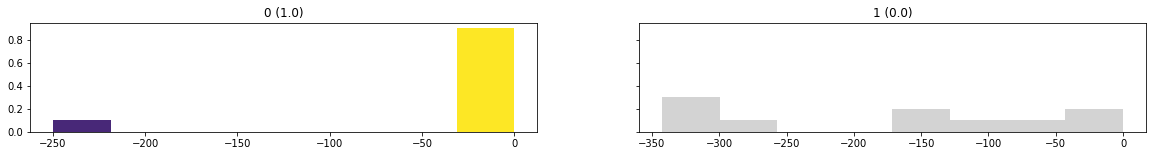

Correct


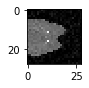

Real:  1


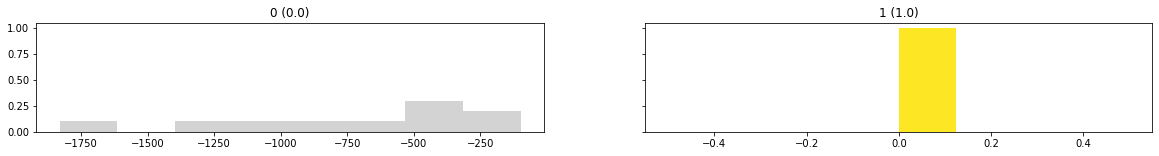

Correct


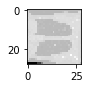

Real:  0


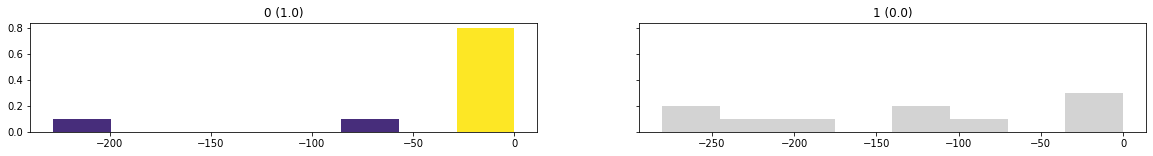

Correct


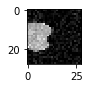

Real:  1


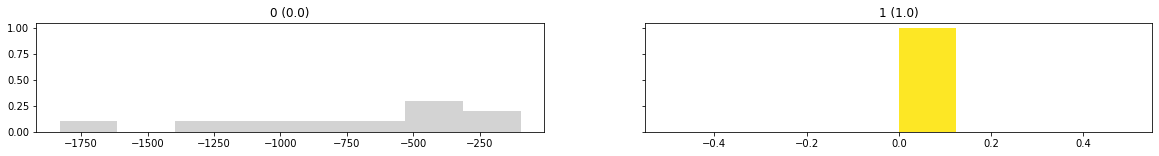

Correct


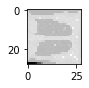

Real:  1


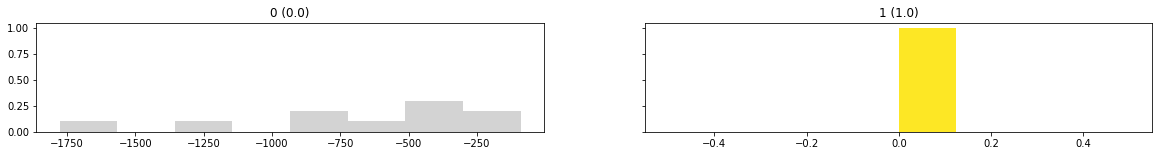

Correct


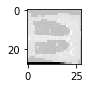

Real:  1


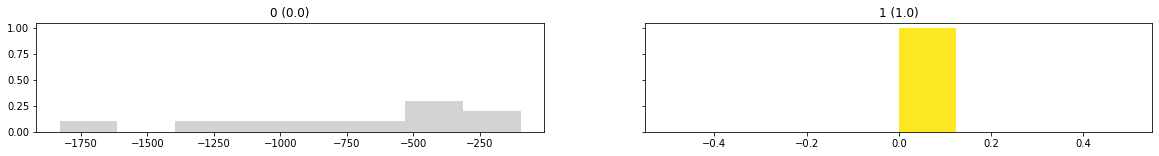

Correct


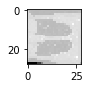

Real:  0


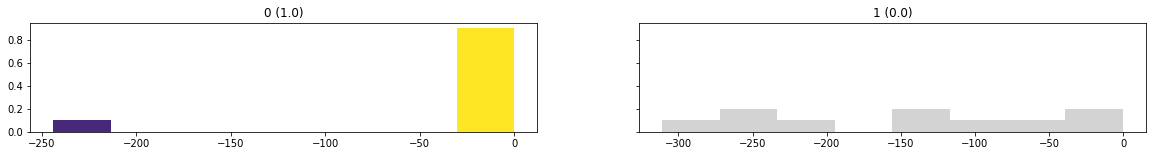

Correct


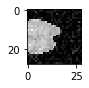

Real:  0


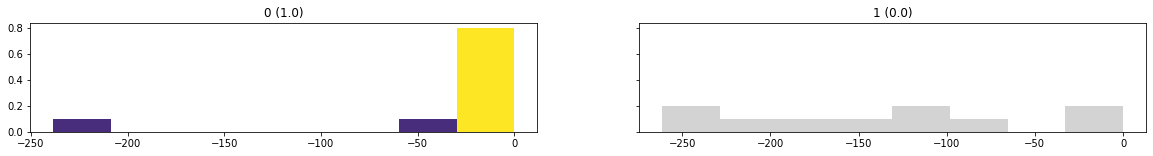

Correct


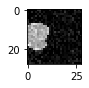

Real:  0


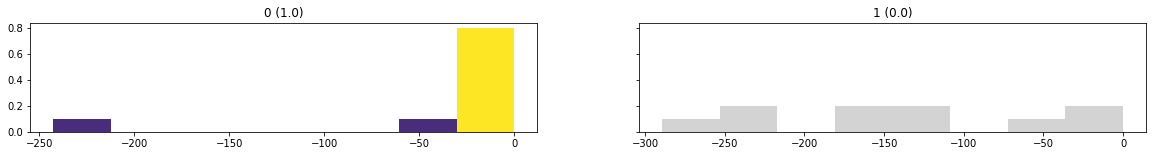

Correct


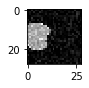

Real:  0


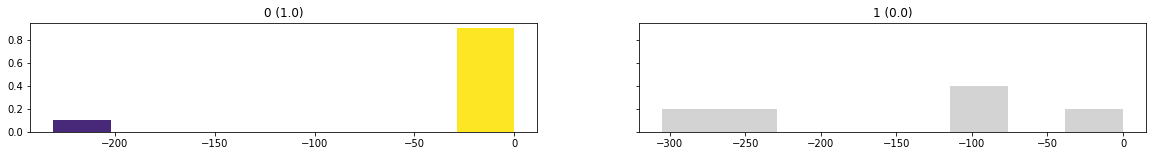

Correct


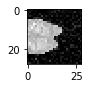

Real:  1


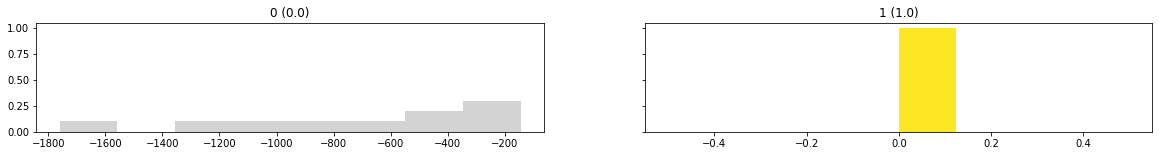

Correct


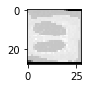

Real:  0


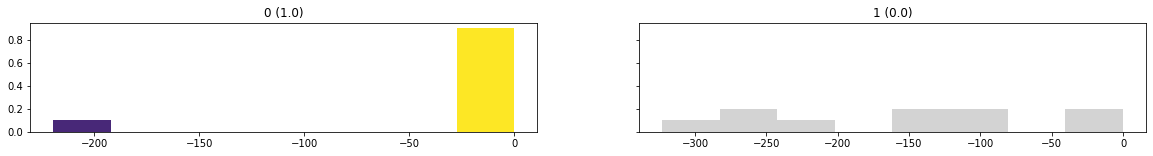

Correct


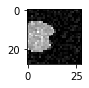

Real:  0


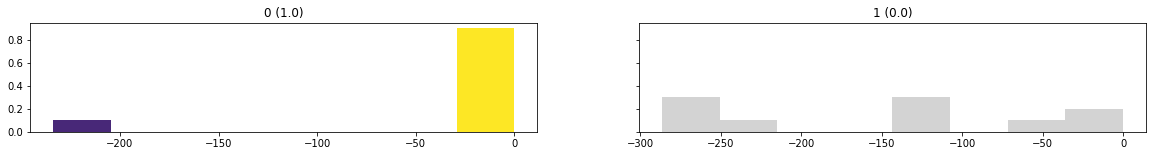

Correct


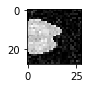

Real:  0


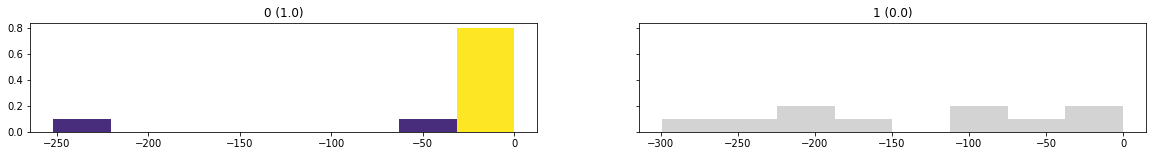

Correct


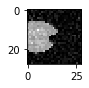

Real:  0


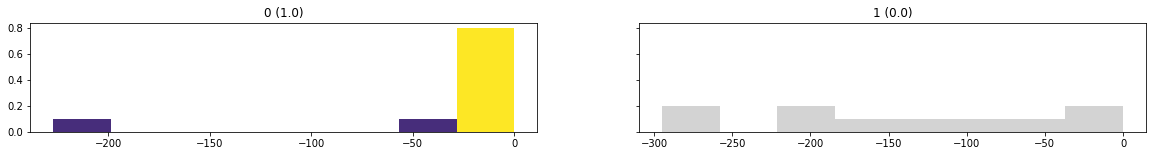

Correct


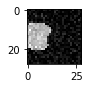

Real:  1


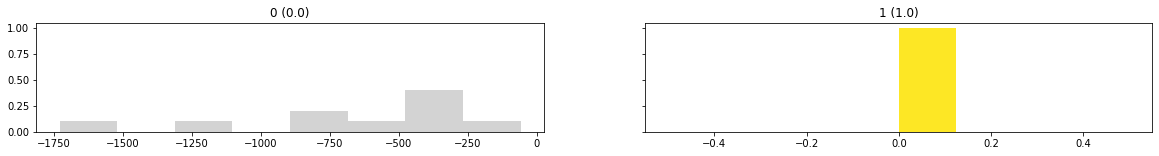

Correct


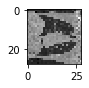

Real:  0


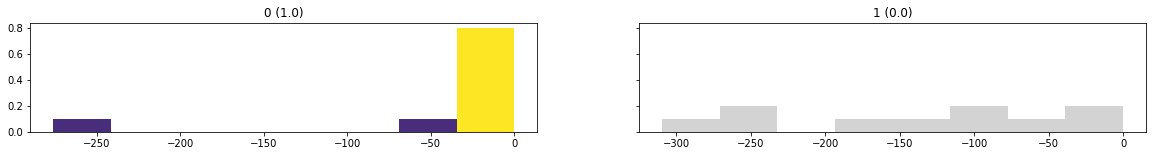

Correct


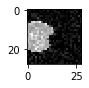

Real:  1


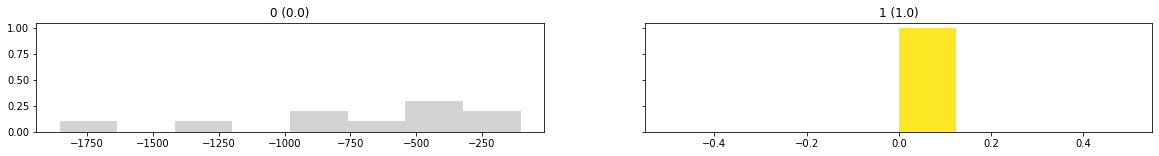

Correct


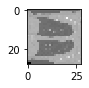

Real:  1


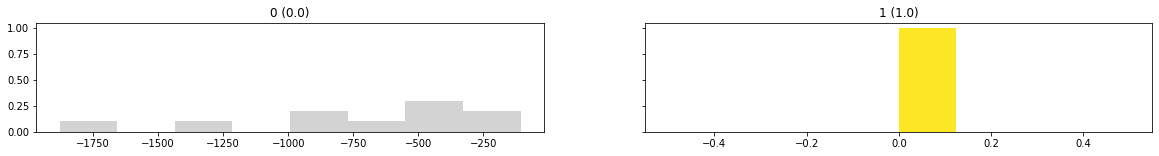

Correct


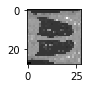

Real:  0


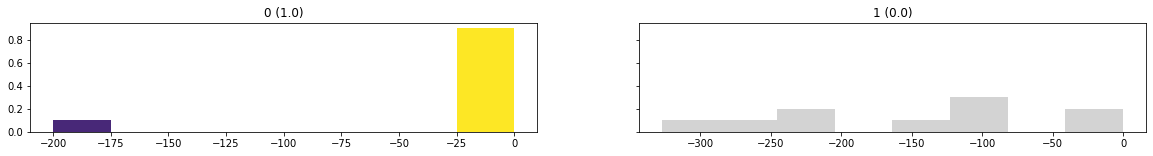

Correct


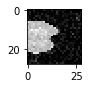

Real:  1


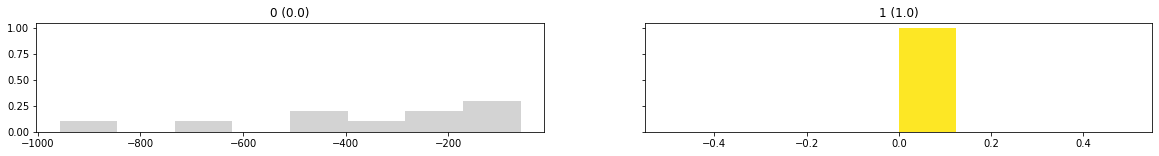

Correct


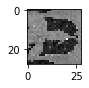

Real:  1


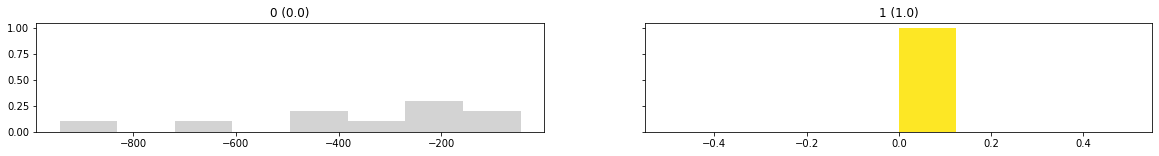

Correct


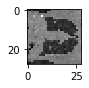

Real:  0


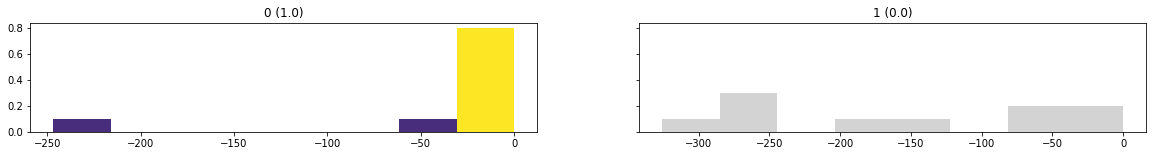

Correct


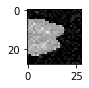

Real:  1


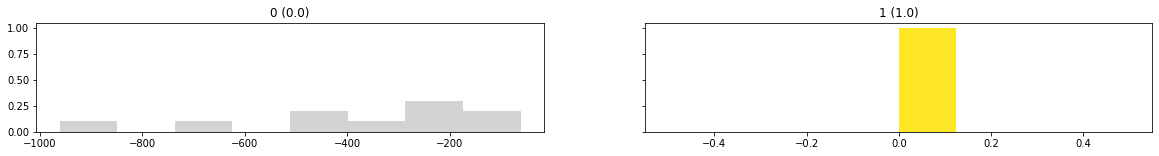

Correct


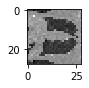

Real:  0


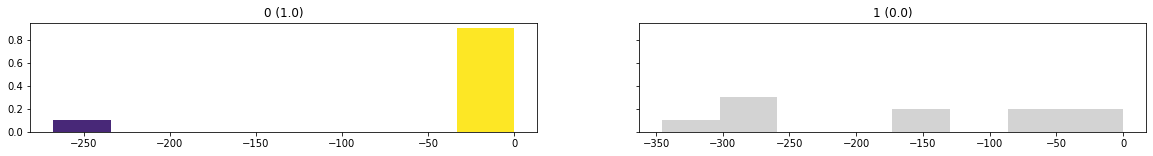

Correct


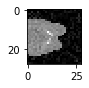

Real:  0


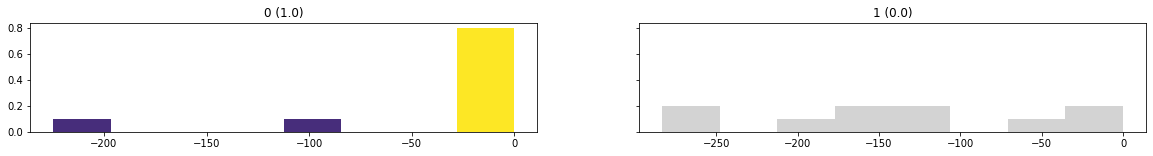

Correct


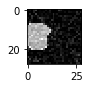

Real:  1


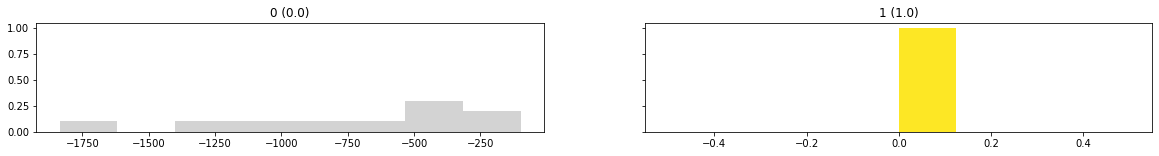

Correct


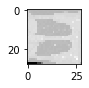

Real:  0


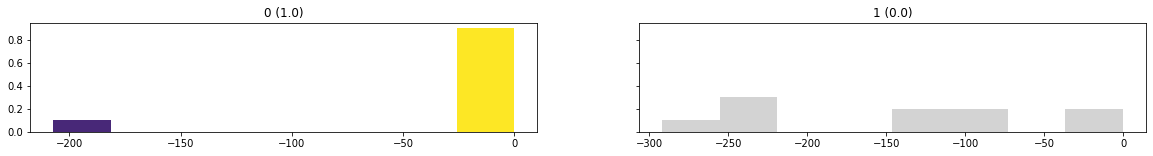

Correct


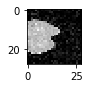

Real:  1


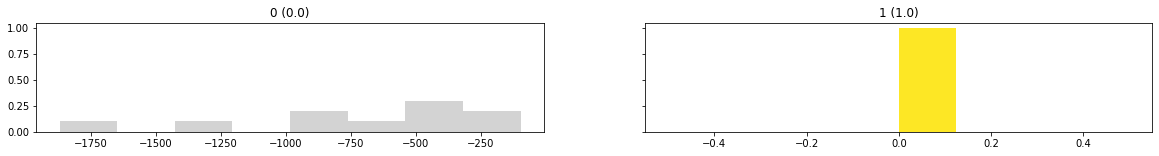

Correct


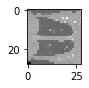

Real:  1


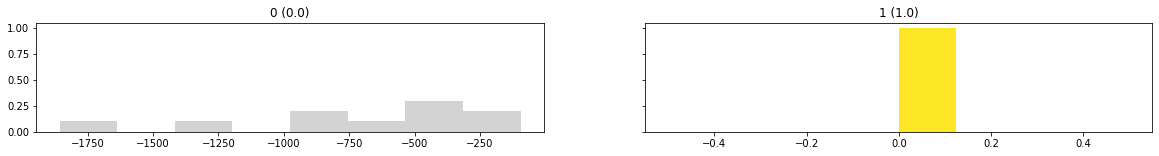

Correct


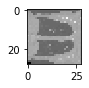

Real:  0


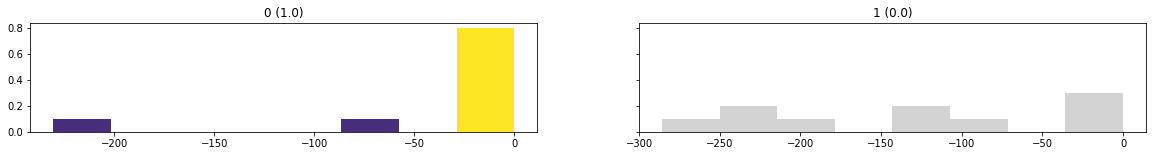

Correct


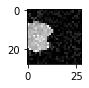

Real:  0


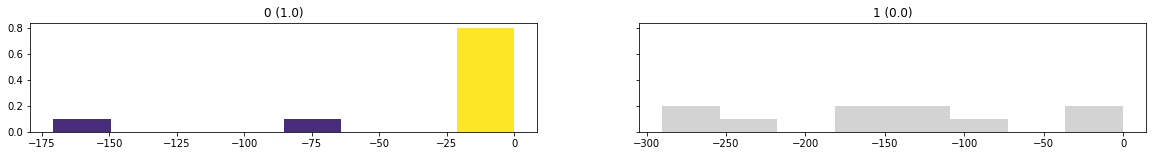

Correct


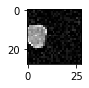

Real:  1


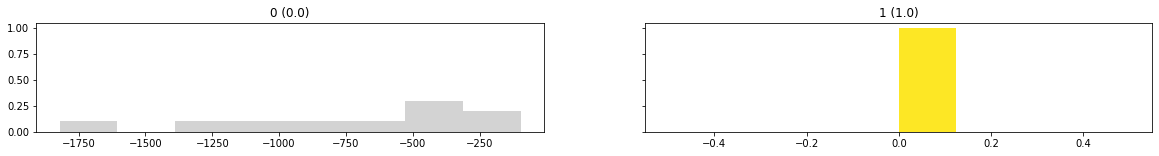

Correct


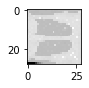

Real:  0


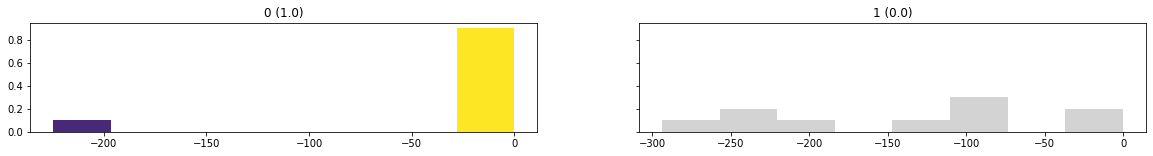

Correct


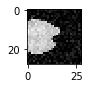

Real:  1


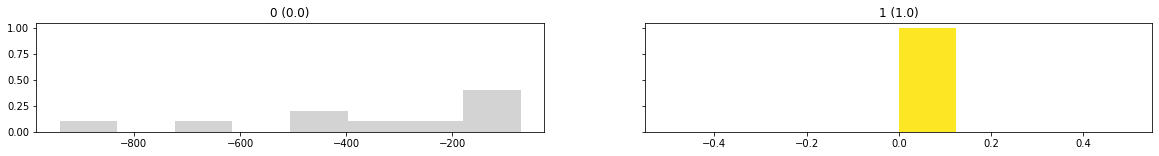

Correct


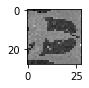

Real:  1


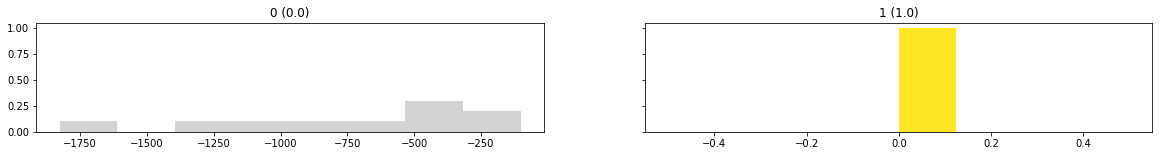

Correct


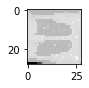

Real:  1


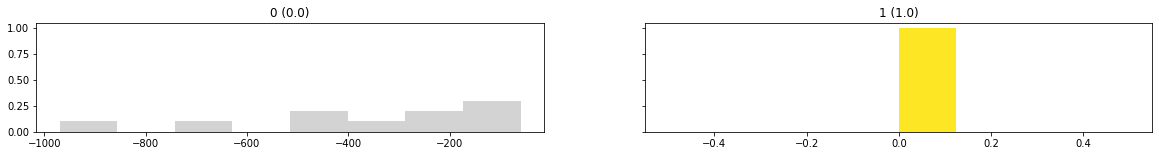

Correct


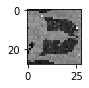

Real:  1


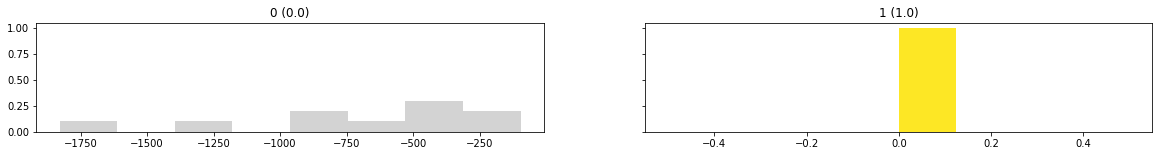

Correct


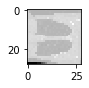

Real:  0


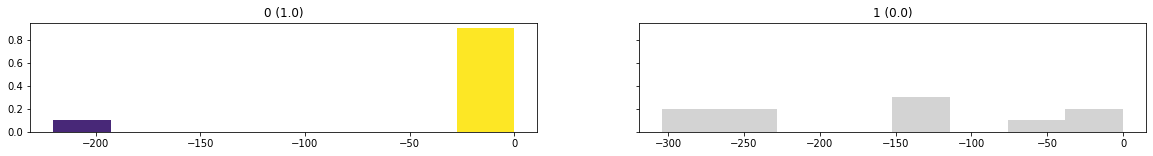

Correct


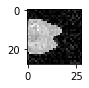

Summary
Total images:  78
Predicted for:  78
Accuracy when predicted:  1.0


(78, 78.0, 78)

In [30]:
test_batch(images[:78], labels[:78])